### Escopo para cálculo de parâmetros da aba Maturação 

In [155]:
# Input de dados de pirólise (leitura de planilha .csv)
# Agrupamento de dados (cluster)
# Cálculo de COTa
# Cálculo de IHa = 100 x (S2/(COTa))
# Calculo de Tr sem vitrinita: (IHa - IH)/ IHa
# Cálculo de Ro a partir de Tmax: Ro calculada = (0,0180 x Tmax) - 7,16
# Classificação do querogênio
# Cálculo de Tr por Ro e tipo de querogênio
# Normalização dos valores de Tr na curva log (ln)
# Cálculo de TOC0, S20 e IH0
# Comparação entre os resultados de Tr (Ro x IH)
# Decisão sobre resultados de Tr
# Output (Gráficos e Planilha)  

##### Dependências

In [156]:
%matplotlib inline
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

##### Customização dos gráficos

In [157]:
# keys = plt.rcParams.keys()
# print(keys)
# 'font.sans-serif': "Verdana",

custom_style = {
    'figure.figsize': (8, 6),
    'font.family':'sans-serif',
    'axes.facecolor': 'lightgray',
    'figure.facecolor':'silver',
    'scatter.marker': 'o',
    'font.size': 9,
    'axes.grid': True
    }

##### Input de dados de pirólise (leitura de planilha .csv)

In [158]:
df1 = pd.read_csv("Poços_Marinho/1-ALS-2-AL.csv")
df=df1[["Profundidade","COT","S1","S2","S3","Tmax","IH","IO"]]
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43
...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78


##### Agrupamento por parâmetros de pirólise

/home/rodrigo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


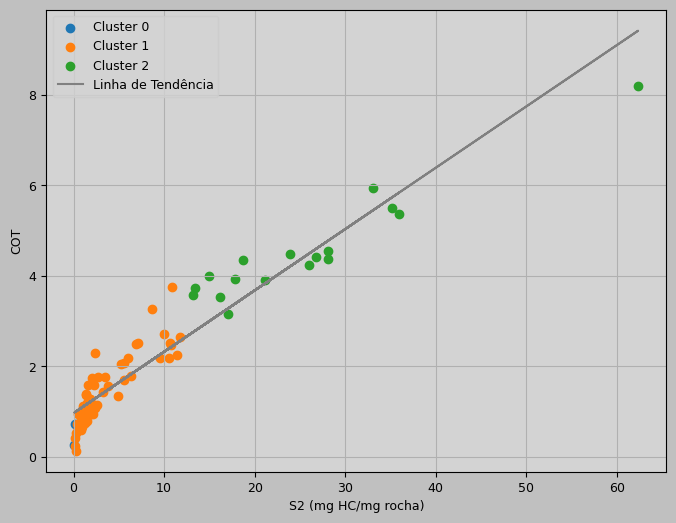

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1
...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0


In [159]:
# Number of clusters you want to create
num_clusters = 3  

# Extract the columns for clustering

X = df[["COT","S1","S2","S3","Tmax"]].fillna(0)

# Optional: Scale the data (if needed)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)  # Use X_scaled if you scaled the data, otherwise use X

# Get cluster assignments and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add cluster labels to the original data frame
df['Cluster'] = cluster_labels

# Scatter plot
plt.figure(figsize=(8, 6))

# Plot data points for each cluster
for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data["S2"], cluster_data["COT"], label=f'Cluster {cluster_id}')

# Extract data from DataFrame
df1=df.dropna(subset=["COT","S2"])
x_data = df1['S2'].values.reshape(-1, 1)
y_data = df1['COT'].values

# Fit linear regression model
model = LinearRegression()
model.fit(x_data, y_data)

# Get the slope (coefficient) and y-intercept of the trend line
slope = model.coef_[0]
intercept = model.intercept_


# Plot the trend line
plt.plot(x_data, model.predict(x_data), color='gray', label='Linha de Tendência')

plt.xlabel("S2 (mg HC/mg rocha)")
plt.ylabel("COT")
plt.title('')
plt.legend()
plt.grid(True)
plt.style.use(custom_style)
plt.show()
df

##### Equação de regressão linear para cada cluster

In [160]:
models = {}

for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    x_values = cluster_data[["S2"]].fillna(value=0)
    y_values = cluster_data["COT"]
    model = LinearRegression()
    model.fit(x_values, y_values)
    models[cluster_id] = model

# Print the linear regression equations for each cluster
dic={}
for cluster_id, model in models.items():
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"Cluster {cluster_id} - y = {slope:.2f} * x + {intercept:.2f}")
    #dic={cluster_id:intercept}
    dic[cluster_id]=intercept
    print(dic)

Cluster 0 - y = -0.85 * x + 0.71
{0: 0.7080097087378642}
Cluster 1 - y = 0.19 * x + 0.79
{0: 0.7080097087378642, 1: 0.7940621234463975}
Cluster 2 - y = 0.09 * x + 2.15
{0: 0.7080097087378642, 1: 0.7940621234463975, 2: 2.146608469927514}


In [161]:
dic[1]

0.7940621234463975

##### Cálculo de COT ativo utilizando regressão linear

In [162]:
COTativo=[]
for idx,row in df.iterrows():
    #print(row["Cluster"])
    Cluster=row["Cluster"]
    COT=row["COT"]
    intercept=dic[Cluster]
    COTa= COT- intercept
    COTativo.append(COTa)
df["COTa"]=COTativo
df
COT_cor=[]
for i in df["COTa"]:
    if i >= 0:
        COT_cor.append(i)
    else:
        COT_cor.append(0)
df["COTa"]=COT_cor
df


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938
...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990


##### Cálculo de IH0ativo
* IHa = 100 x (S2/(COTa))

In [163]:
IHa = (100*df["S2"]/df["COTa"])
IHa_cor=[]
for i in IHa:
    if i<0:
        IHa_cor.append(0)
    elif i>999:
        IHa_cor.append(999)
    else:
        IHa_cor.append(i) # Eliminar valores
df["IH0a"]= IHa_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,IH0a
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,401.538655
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,415.516208
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,436.527503
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,417.082078
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,354.883158
...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,999.000000
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,999.000000
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,999.000000


##### Calculo da Taxa de Transformação sem Ro (IH)
* (IHa - IH)/ IHa

In [164]:
df["Taxa de Transformação (IH)"] = ((df["IH0a"]-df["IH"])/df["IH0a"])
TrIH=[]
for i in df["Taxa de Transformação (IH)"]:
    if i<0:
        TrIH.append(0)
    elif i>1:
        TrIH.append=1
    else:
        TrIH.append(i)
df["Taxa de Transformação (IH)"]=TrIH
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,401.538655,0.317625
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,415.516208,0.316368
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,436.527503,0.364255
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,417.082078,0.385469
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,354.883158,0.615564
...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,999.000000,0.954124
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,999.000000,0.961502
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,999.000000,0.972192


##### Cálculo de Ro a partir de Tmax
* Ro calculada = (0,0180 x Tmax) - 7,16

In [165]:
df["Ro (calculada)"] = (0.0180*df["Tmax"])-7.16
Roc_cor=[]
for i in df["Ro (calculada)"]:
    if i<0:
        Roc_cor.append(0)
    else:
        Roc_cor.append(i)
df["Ro (calculada)"]=Roc_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,401.538655,0.317625,0.580
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,415.516208,0.316368,0.562
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,436.527503,0.364255,0.580
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,417.082078,0.385469,0.580
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,354.883158,0.615564,0.544
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,999.000000,0.954124,0.814
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,999.000000,0.961502,NaN
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,999.000000,0.972192,NaN


#### Classificação do querogênio
* Tipo I: {IH > 600} ___ {S1/S3 > 15}
* Tipo II: {IH > 300 and IH <= 600} ___ {S1/S3 > 10 and S1/S3 <15}
* Tipo II/III: {IH > 200 and IH <=300} ___ {S1/S3 > 5 and S1/S3 < 10]
* Tipo III: {IH > 50 and IH <= 200} ___ {S1/S3 > 1 and S1/S3 < 5}
* Tipo IV: {IH <= 50} ___ {S1/S3 > 1}

In [166]:

K = []
for i in df["IH"]:
    if i > 600:
        a="I"
    elif i > 300 and i <=600:
        a="II"
    elif i > 200 and i <= 300:
        a="II/III"
    elif i > 50 and i <= 200:
        a="III"
    elif i>0 and i<=50:
        a="IV"
    else:
        a=""
    K.append(a)
querogênio=pd.DataFrame(K)
df["Querogênio"]=querogênio
df


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,401.538655,0.317625,0.580,II/III
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,415.516208,0.316368,0.562,II/III
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,436.527503,0.364255,0.580,II/III
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,417.082078,0.385469,0.580,II/III
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,354.883158,0.615564,0.544,III
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,999.000000,0.954124,0.814,IV
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,999.000000,0.961502,NaN,IV
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,999.000000,0.972192,NaN,IV


#### End Member para tipo de querogênio

In [167]:
# End Member

T1 = []
T2 = []
T3 = []
T4 = []
for i in df["IH"]: 
    if i >= 800:
        end = ((i - 999)/(800 - 999))*100
        T1.append(100) 
        T2.append(0)
        T3.append(0)
        T4.append(0) 
    elif i >= 425 and i <=800:
        end = ((i - 800)/(425 - 800))*100
        T1.append(100-end) 
        T2.append(end)
        T3.append(0)
        T4.append(0) 
    elif i >= 150 and i < 425:
        end = ((i - 425)/(150 - 425))*100
        T1.append(0) 
        T2.append(100-end)
        T3.append(end)
        T4.append(0) 
    elif i >=25 and i < 150:
        end = ((i - 150)/(25 - 150))*100
        T1.append(0) 
        T2.append(0)
        T3.append(100-end)
        T4.append(end) 
    elif i>=0 and i < 25:
        T1.append(0) 
        T2.append(0)
        T3.append(0)
        T4.append(100) 
    else:
        T1.append(0) 
        T2.append(0)
        T3.append(0)
        T4.append(0) 

df["% Tipo I"]=T1
df["% Tipo II"]=T2
df["% Tipo III"]=T3
df["% Tipo IV"]=T4
df.to_csv("Planilha.csv")
df





,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,IH0a,Taxa de Transformação (IH),Ro (calculada),Querogênio,% Tipo I,% Tipo II,% Tipo III,% Tipo IV
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,401.538655,0.317625,0.580,II/III,0.0,45.090909,54.909091,0.000
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,415.516208,0.316368,0.562,II/III,0.0,48.749091,51.250909,0.000
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,436.527503,0.364255,0.580,II/III,0.0,46.370909,53.629091,0.000
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,417.082078,0.385469,0.580,II/III,0.0,38.658182,61.341818,0.000
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,354.883158,0.615564,0.544,III,0.0,0.000000,89.144000,10.856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,NaN,NaN,NaN,,0.0,0.000000,0.000000,0.000
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,999.000000,0.954124,0.814,IV,0.0,0.000000,16.664000,83.336
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,999.000000,0.961502,NaN,IV,0.0,0.000000,10.768000,89.232
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,999.000000,0.972192,NaN,IV,0.0,0.000000,2.224000,97.776


#### Decisão sobre tipo de Querogênio

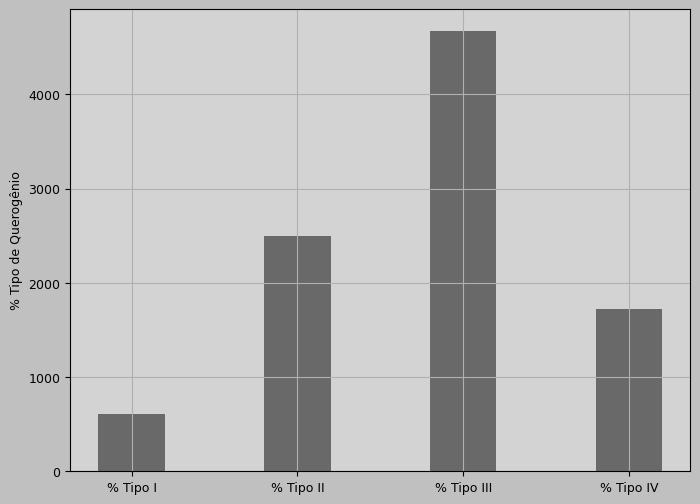

In [168]:
x=['% Tipo I', '% Tipo II', '% Tipo III', '% Tipo IV']
TI=df["% Tipo I"].dropna().values.sum()
TII=df["% Tipo II"].dropna().values.sum()
TIII=df["% Tipo III"].dropna().values.sum()
TIV=df["% Tipo IV"].dropna().values.sum()
data=[TI,TII,TIII,TIV]
plt.bar(x,data,0.4, facecolor="dimgray")
#custom_labels_x = ['% Tipo I', '% Tipo II', '% Tipo III', '% Tipo IV']
#plt.xticks(np.arange(1, len(custom_labels_x) + 1), custom_labels_x)
plt.style.use(custom_style)
plt.ylabel("% Tipo de Querogênio")
plt.savefig("Boxplot_K.pdf")
plt.show()

#### Cálculo de Tr por Ro e tipo de querogênio
* Tipo_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
* Tipo_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
* Tipo_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)


In [169]:
Ro = df["Ro (calculada)"].mean()
print("Valor medio da Ro calculada:", Ro )
#for Ro in df["Ro (calculada)"]:
Eq_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
Eq_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
Eq_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)
    
if TI > TII and TI > TIII and TI > TIV:
    TRo=Eq_I
    print("Querogênio Tipo I")
elif TII > TI and TII > TIII and TII > TIV:
    TRo=Eq_II
    print("Querogênio Tipo II")
elif TIII > TI and TIII > TII and TIII > TIV:
    TRo=Eq_III
    print("Querogênio Tipo III")
else:
    TRo=0
    print("Querogênio Tipo IV")
print("Taxa de TRansformação (Ro):", TRo)

if i > 1:
    TRo = 1
elif TRo < 0:
    TRo = 0
else:
    TRo = TRo
#df["Taxa de Transformação (Ro)"]=TRo
#df

Valor medio da Ro calculada: 0.6936129032258057
Querogênio Tipo III
Taxa de TRansformação (Ro): 0.05867102297416635


#### Normalização dos valores de Tr na curva log (ln)

In [170]:
L = float(input("Lâmina d'água: "))


MRo = TRo#df["Taxa de Transformação (Ro)"].mean()
MIH = df["Taxa de Transformação (IH)"].median()
MinIH = df["Taxa de Transformação (IH)"].min()
MedIH = df["Taxa de Transformação (IH)"].mean()

    # 4. Ajustar uma curva logaritmica com a profundidade da lamina dagua e a profundidade final e o tr na lamina dagua (zero) e o tr na profundidade final (mediana ou mínimo), utilizando scipy curve_fit

# Cálculo para valores de Ro calculada
x1 = [L, df["Profundidade"].max()]
y1 = [0, MRo]

log_fit = scipy.optimize.curve_fit(lambda t, a1, b1: a1 + b1 * np.log(t), x1, y1)
a1 = log_fit[0][0]
b1 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_Ro_Log'] = a1 + b1 * np.log(df["Profundidade"])

#================================================#

# Cálculo para valores de IH (mediana)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (mdn)'] = a2 + b2 * np.log(df["Profundidade"])
df

#================================================#

# Cálculo para valores de IH (mínimo)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MinIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (min)'] = a2 + b2 * np.log(df["Profundidade"])
df
#================================================#

# Cálculo para valores de IH (média)
x2 = [L, df["Profundidade"].max()]
y2 = [0, MedIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log (med)'] = a2 + b2 * np.log(df["Profundidade"])
df
    # Extra: aplicando novamente filtro para que tr seja 0 abaixo da lamina d'agua


/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,Ro (calculada),Querogênio,% Tipo I,% Tipo II,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,0.580,II/III,0.0,45.090909,54.909091,0.000,0.037930,0.424264,0.136523,0.401358
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,0.562,II/III,0.0,48.749091,51.250909,0.000,0.038291,0.428294,0.137819,0.405171
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,0.580,II/III,0.0,46.370909,53.629091,0.000,0.038640,0.432204,0.139078,0.408870
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,0.580,II/III,0.0,38.658182,61.341818,0.000,0.038980,0.436002,0.140300,0.412463
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,0.544,III,0.0,0.000000,89.144000,10.856,0.039310,0.439694,0.141488,0.415955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,NaN,,0.0,0.000000,0.000000,0.000,0.058374,0.652928,0.210104,0.617677
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,0.814,IV,0.0,0.000000,16.664000,83.336,0.058384,0.653048,0.210143,0.617791
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,NaN,IV,0.0,0.000000,10.768000,89.232,0.058438,0.653648,0.210336,0.618358
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,NaN,IV,0.0,0.000000,2.224000,97.776,0.058555,0.654958,0.210757,0.619598


#### Gráficos das curvas Log para Taxa de Transformação

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


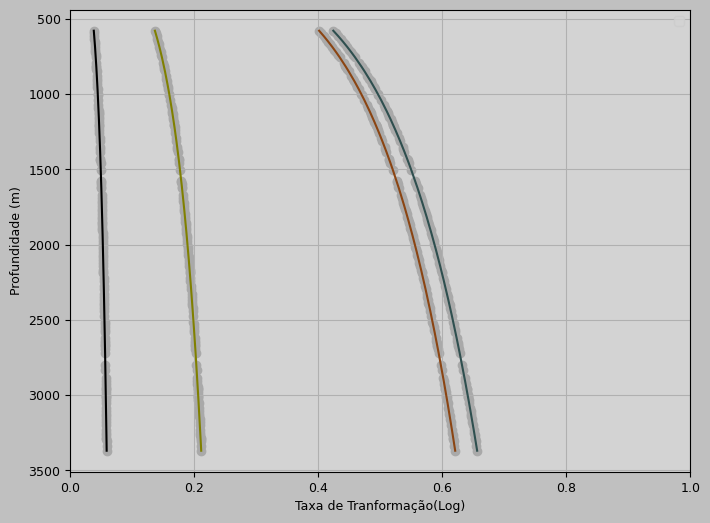

In [171]:
fig = plt.figure()
ax = fig.add_subplot()
y = df["Profundidade"].values
mdn = df["Tr_IH_Log (mdn)"].values
min = df["Tr_IH_Log (min)"].values
med = df["Tr_IH_Log (med)"].values
Ro = df["Tr_Ro_Log"].values
ax.plot(mdn, y, color='darkslategray')
ax.plot(min, y, color='olive')
ax.plot(med, y, color='saddlebrown')
ax.plot(Ro, y, color='black')
ax.scatter(mdn, y, color='darkgray')
ax.scatter(min, y, color='darkgray')
ax.scatter(med, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.savefig("Curvas_Tr.pdf")
plt.show()

#### Decisão sobre a curva Log 

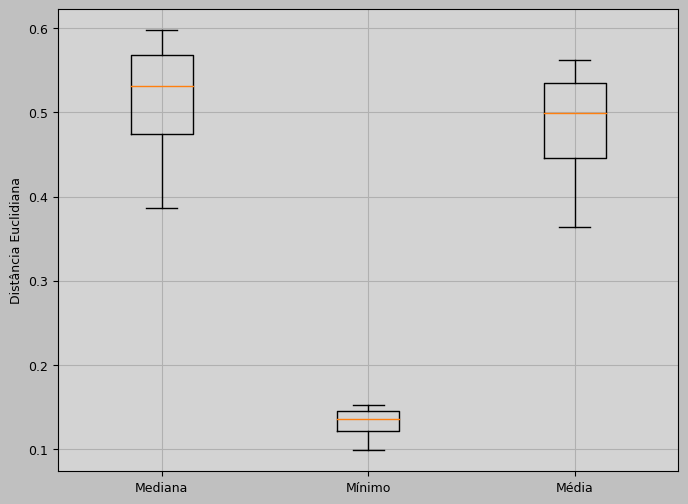

In [172]:
sub1=np.sqrt((df["Tr_IH_Log (mdn)"]-df["Tr_Ro_Log"])**2)
sub2=np.sqrt((df["Tr_IH_Log (min)"]-df["Tr_Ro_Log"])**2)
sub3=np.sqrt((df["Tr_IH_Log (med)"]-df["Tr_Ro_Log"])**2)
data=[sub1,sub2,sub3]
plt.boxplot(data)
custom_labels_x = ['Mediana', 'Mínimo', 'Média']
plt.xticks(np.arange(1, len(custom_labels_x) + 1), custom_labels_x)
plt.style.use(custom_style)
plt.ylabel("Distância Euclidiana")
plt.savefig("Boxplot_DistEuc.pdf")
plt.show()


#### Gráfico final (output) para Taxa de Transformação

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


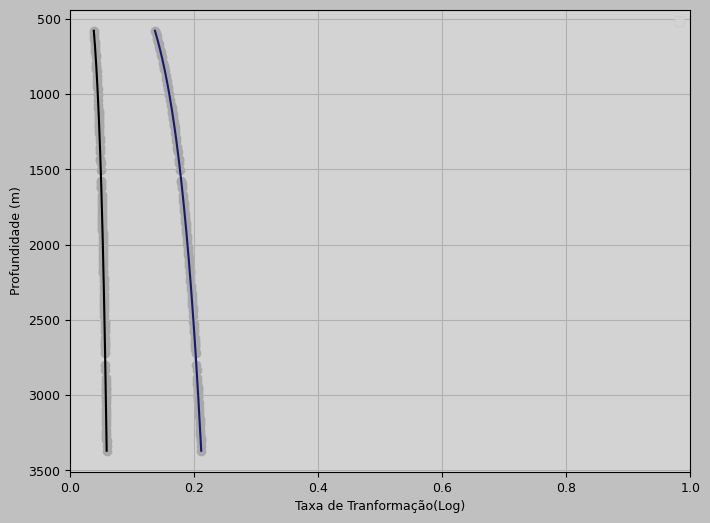

In [173]:
fig = plt.figure()
ax = fig.add_subplot()
#y = df["Profundidade"].values
#mdn = df["Tr_IH_Log (mdn)"].values
#min = df["Tr_IH_Log (min)"].values
#med = df["Tr_IH_Log (med)"].values
#Ro = df["Tr_Ro_Log"].values

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    a=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    a=min
else:
    a=med

ax.plot(a, y, color='midnightblue')
ax.plot(Ro, y, color='black')
ax.scatter(a, y, color='darkgray')
ax.scatter(Ro, y, color='darkgray')
plt.legend()
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação(Log)")
plt.ylabel("Profundidade (m)")
plt.savefig("Boxplot_Tr.pdf")
plt.style.use(custom_style)
plt.show()

##### Cálculo de TOC0, S20 e IH0
* S20 = S2 / (1 - Tr)
* COT0 = COTr + ((S2 x tr)/(1 - Tr))x0,086
* IH0 = S20/COT0

In [174]:
Tr = df["Taxa de Transformação (IH)"]
df["S20"]=df["S2"]/(1-Tr)
df["COT0"]=df["COT"]+((df["S2"]*Tr)/(1-Tr))*0.086
df["IH0"]=100*df["S20"]/df["COT0"]
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,% Tipo II,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,45.090909,54.909091,0.000,0.037930,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,48.749091,51.250909,0.000,0.038291,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,46.370909,53.629091,0.000,0.038640,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,38.658182,61.341818,0.000,0.038980,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,0.000000,89.144000,10.856,0.039310,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,0.000000,0.000000,0.000,0.058374,0.652928,0.210104,0.617677,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,0.000000,16.664000,83.336,0.058384,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,0.000000,10.768000,89.232,0.058438,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,0.000000,2.224000,97.776,0.058555,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518


#### Cálculo de OSI

In [175]:
df["OSI"]=((df["S1"]/df["COT"])*100)
df.to_csv("Reunião_PR4_08_23.csv")
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,% Tipo III,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0,OSI
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,54.909091,0.000,0.037930,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796,12.800000
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,51.250909,0.000,0.038291,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793,11.553785
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,53.629091,0.000,0.038640,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410,10.091743
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,61.341818,0.000,0.038980,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316,12.621359
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,89.144000,10.856,0.039310,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535,13.178295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,0.000000,0.000,0.058374,0.652928,0.210104,0.617677,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,16.664000,83.336,0.058384,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629,27.777778
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,10.768000,89.232,0.058438,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170,38.461538
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,2.224000,97.776,0.058555,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518,27.777778


#### Gráfico OSI

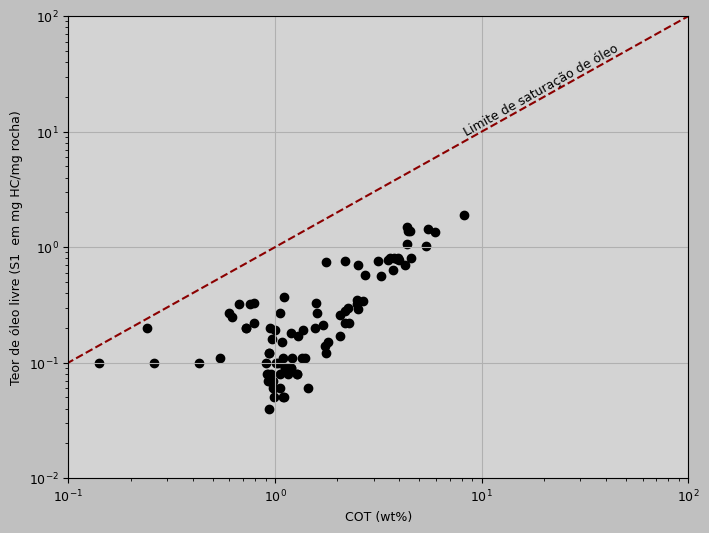

In [176]:
plt.plot([0,100],[0,100], color="darkred", linestyle="--")
plt.scatter(df["COT"], df["S1"], color="black")
plt.ylabel("Teor de óleo livre (S1  em mg HC/mg rocha)")
plt.xlabel("COT (wt%)")
plt.text(8.0, 9.3, "Limite de saturação de óleo", rotation=29.3)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.1,100.0)
plt.ylim(0.01,100.0)
plt.show()

#### Diagrama de Van Krevelen

In [177]:
df["S2/S3"]=df["S2"]/df["S3"]
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,% Tipo IV,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0,OSI,S2/S3
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,0.000,0.037930,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796,12.800000,5.614754
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,0.000,0.038291,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793,11.553785,5.614173
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,0.000,0.038640,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410,10.091743,4.801587
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,0.000,0.038980,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316,12.621359,4.800000
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,10.856,0.039310,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535,13.178295,1.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,0.000,0.058374,0.652928,0.210104,0.617677,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,83.336,0.058384,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629,27.777778,1.736842
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,89.232,0.058438,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170,38.461538,0.333333
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,97.776,0.058555,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518,27.777778,1.000000


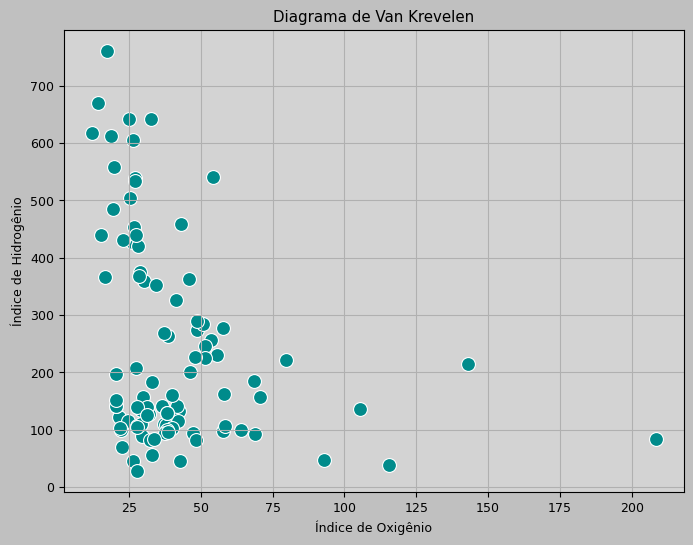

In [178]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df["IO"], y=df["IH"], marker='o', color='darkcyan', s=100)
plt.xlabel("Índice de Oxigênio")
plt.ylabel("Índice de Hidrogênio")
plt.title("Diagrama de Van Krevelen")
plt.grid(True)
plt.show()

## Figura com gráficos de Output

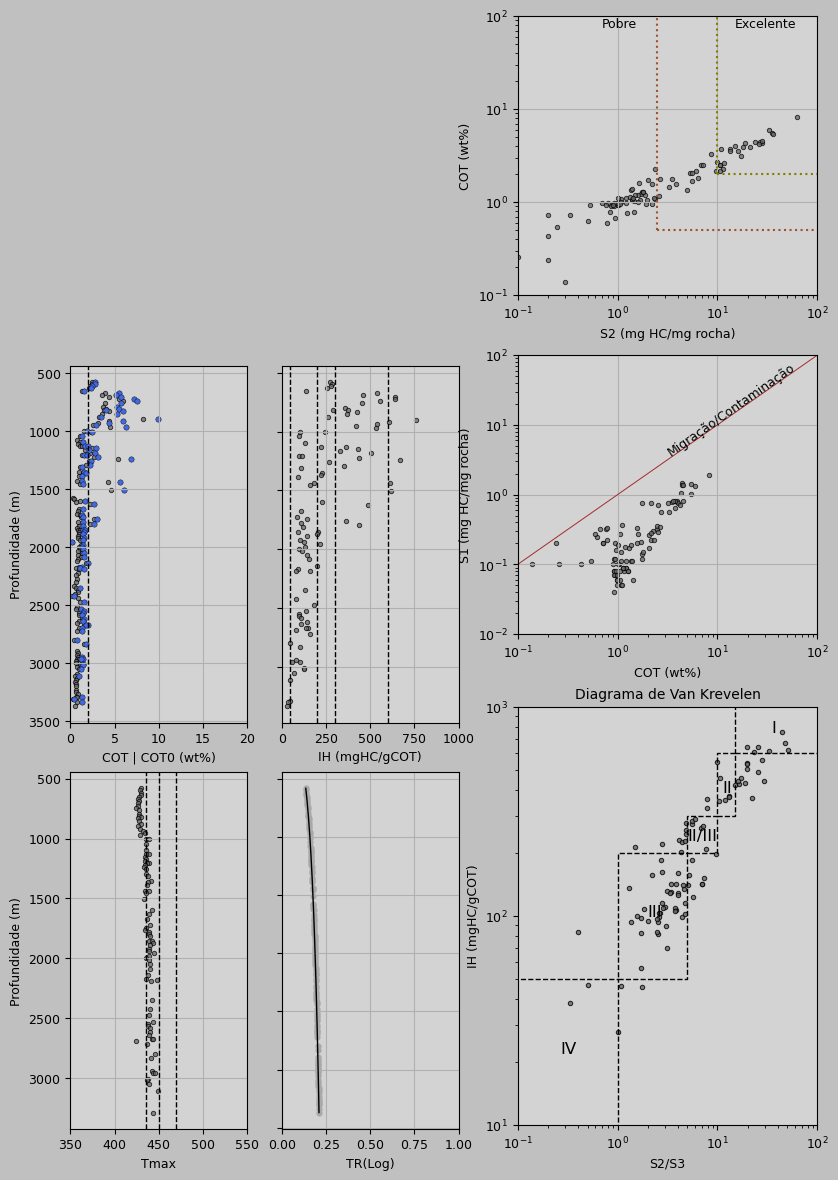

In [179]:
# Figura com tamanho A4

a4_width = 8.27  # inches
a4_height = 11.69  # inches

fig = plt.figure(figsize=(a4_width, a4_height), layout='constrained')

# Grid

L1 = GridSpec(3,4, figure=fig, width_ratios=[1, 1,1,2], height_ratios=[1,1, 1.5])
L2 = GridSpec(3,4, figure=fig)

# Posição dos gráficos 

ax1=fig.add_subplot(L2[1,0]) #==== COT ======#
ax2=fig.add_subplot(L2[1,1]) #==== IH ======#
ax3=fig.add_subplot(L2[2,0]) #==== Tmax ======#
ax4=fig.add_subplot(L2[2,1]) #==== Tr (log) ======#
ax5=fig.add_subplot(L1[2,-1]) #=== Van krevelen ===#
ax6=fig.add_subplot(L1[0,-1]) #===COT x S2 ====#
#ax7=fig.add_subplot(spec[2,3]) #=== OSI ===#
ax8=fig.add_subplot(L1[1,-1]) #== OSI (S1 x COT)==#
plt.style.use(custom_style)

#==== COT ======#

ax1.scatter(df["COT"], df["Profundidade"], color="dimgray",s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax1.scatter(df["COT0"], df["Profundidade"],s=15,c="royalblue", edgecolor="black", linewidth=0.3)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xlim(0.0, 20.0)
ax1.axvline(2, color="black", linewidth=1, linestyle="--")
ax1.set_xlabel("COT | COT0 (wt%)")
ax1.set_ylabel("Profundidade (m)")

#==== IH ======#

ax2.scatter(df["IH"], df["Profundidade"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax2.axvline(600, color="black", linewidth=1, linestyle="--")
ax2.axvline(300, color="black", linewidth=1, linestyle="--")
ax2.axvline(200, color="black", linewidth=1, linestyle="--")
ax2.axvline(50, color="black", linewidth=1, linestyle="--")
ax2.set_xlabel("IH (mgHC/gCOT)")
ax2.set_xlim(0.0, 1000.0)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_yticklabels([])
ax2.set_ylabel("")

#==== Tmax ======#

ax3.scatter(df["Tmax"], df["Profundidade"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.axvline(435, color="black", linewidth=1, linestyle="--")
ax3.axvline(450, color="black", linewidth=1, linestyle="--")
ax3.axvline(470, color="black", linewidth=1, linestyle="--")
ax3.set_xlabel("Tmax")
ax3.set_ylabel("Profundidade (m)")
ax3.set_xlim(350,550)

#==== Tr (log) ======#

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    a=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    a=min
else:
    a=med

ax4.plot(a, y, color='black', linewidth=1)
ax4.scatter(a, y, color='darkgray', s=12)
ax4.set_ylim(ax4.get_ylim()[::-1])
ax4.set_xlabel("TR(Log)")
ax4.set_ylabel("")
ax4.set_yticklabels([])
ax4.set_xlim(0,1)

#====== Van krevelen ======#

ax5.scatter(df["S2/S3"], df["IH"], color="dimgray", edgecolor="black", s=10, linewidth=0.75, alpha=0.8)
ax5.add_patch(patches.Rectangle((15,600),400,500, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo 1
ax5.add_patch(patches.Rectangle((10,300),5,300, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo II
ax5.add_patch(patches.Rectangle((5,200),5,100, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo II/III
ax5.add_patch(patches.Rectangle((1,50),4,150, linewidth=1, edgecolor='black', facecolor='none', linestyle="--")) # Tipo III
ax5.add_patch(patches.Rectangle((0,0),1,50, linewidth=1, edgecolor='black', facecolor='none', linestyle="--"))  # Tipo IV
ax5.text(35,750, "I", fontsize=12)
ax5.text(11.3,390, "II", fontsize=12)
ax5.text(5.0,230, "II/III", fontsize=12)
ax5.text(2.0,100, "III", fontsize=12)
ax5.text(0.27,22, "IV", fontsize=12)
ax5.set_xscale("log")
ax5.set_yscale("log")
ax5.set_xlim(0.1,100)
ax5.set_ylim(10,1000)
ax5.set_xlabel("S2/S3")
ax5.set_ylabel("IH (mgHC/gCOT)")
ax5.set_title("Diagrama de Van Krevelen", fontsize=10)
ax5.grid(False)

#======== COT x S2 ========#

ax6.scatter(df["S2"], df["COT"], color="dimgray",s=10,edgecolor='black', linewidth=0.65, alpha=0.75 )
ax6.set_xscale("log")
ax6.set_yscale("log")
ax6.plot([10,10],[2,100], color="olive", linestyle=":", linewidth=1.5)
ax6.plot([10,100],[2,2], color="olive", linestyle=":", linewidth=1.5)
ax6.plot([2.5,2.5],[0.5,100], color="sienna", linestyle=":", linewidth=1.5)
ax6.plot([2.5,100],[0.5,0.5], color="sienna", linestyle=":", linewidth=1.5)
ax6.text(15,75, "Excelente")
ax6.text(0.7,75, "Pobre")
ax6.set_xlabel("S2 (mg HC/mg rocha)")
ax6.set_ylabel("COT (wt%)")
ax6.set_xlim(0.1,100)
ax6.set_ylim(0.1,100)

#========== OSI ===========#

#ax7.scatter(df["OSI"], df["Profundidade"], color="black")
#ax7.set_ylim(ax1.get_ylim()[::-1])
#ax7.set_xlim(0.0, 200.0)
#ax7.axvline(100, color="darkred", linestyle="--")
#ax7.set_yticklabels([])
#ax7.set_xlabel("OSI (wt%)")
#ax7.set_ylabel("")

#========= OSI (S1 x COT)============#

ax8.plot([0,100],[0,100], color="brown", linestyle="-", linewidth=0.7)
ax8.scatter(df["COT"], df["S1"], color="dimgray", s=10, edgecolor='black', linewidth=0.65, alpha=0.75)
ax8.set_ylabel("S1 (mg HC/mg rocha)")
ax8.set_xlabel("COT (wt%)")
ax8.text(3.0, 3.7, "Migração/Contaminação", rotation=35)
ax8.set_xlim(0.1,100.0)
ax8.set_ylim(0.01,100.0)
ax8.set_xscale("log")
ax8.set_yscale("log")


plt.savefig("Outputs_Figuras/Figura.pdf")



# Planilha de Output

In [180]:
mdn1 = df["Tr_IH_Log (mdn)"]
min1 = df["Tr_IH_Log (min)"]
med1 = df["Tr_IH_Log (med)"]

if sub1.mean()+sub1.std() < sub2.mean()+sub2.std() and sub1.mean()+sub1.std() < sub3.mean()+sub3.std():
    b=mdn
elif sub2.mean()+sub2.std() < sub1.mean()+sub1.std() and sub2.mean()+sub2.std() < sub3.mean()+sub3.std():
    b=min
else:
    b=med
df_csv=df[["Profundidade","COT","S1","S2","S3","Tmax","IH","IO","Cluster"]]
df_csv[["COTa","IH0a"]]=df[["COTa","IH0a"]].round(2)
df_csv["Ro (calculada)"]=df["Ro (calculada)"]
df_csv["Querogênio (Tipo)"]=df["Querogênio"]
df_csv["Tr_Ro_Log"]=df["Tr_Ro_Log"].round(3)
df_csv["Tr_IH_Log"]=b.round(3) 
df_csv[["COT0","S20","IH0","OSI"]]=df[["COT0","S20","IH0","OSI"]].round(2)
df_csv.to_csv("Outputs_Planilhas/Planilha.csv")
df_csv

/tmp/ipykernel_4645/4011761595.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv[["COTa","IH0a"]]=df[["COTa","IH0a"]].round(2)
/tmp/ipykernel_4645/4011761595.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csv[["COTa","IH0a"]]=df[["COTa","IH0a"]].round(2)
/tmp/ipykernel_4645/4011761595.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,IH0a,Ro (calculada),Querogênio (Tipo),Tr_Ro_Log,Tr_IH_Log,COT0,S20,IH0,OSI
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.71,401.54,0.580,II/III,0.038,0.137,2.77,10.04,361.85,12.80
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.72,415.52,0.562,II/III,0.038,0.138,2.79,10.43,373.32,11.55
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.39,436.53,0.580,II/III,0.039,0.139,2.48,9.52,384.02,10.09
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.27,417.08,0.580,II/III,0.039,0.140,2.34,8.59,366.42,12.62
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.50,354.88,0.544,III,0.039,0.141,1.53,4.58,298.76,13.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.00,NaN,NaN,,0.058,0.210,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.00,999.00,0.814,IV,0.058,0.210,1.31,7.19,549.01,27.78
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.00,999.00,NaN,IV,0.058,0.210,0.47,2.60,547.09,38.46
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.01,999.00,NaN,IV,0.059,0.211,1.32,7.19,544.32,27.78


## Parâmetros adicionais

* Índice de Produção Inicial: IP0 = 0.02
* Índice de Produção: PI = S1/(S1+S2)
* f = (1-(HI*(1200-(HI0/(1-PI0))))/(HI0*(1200-(HI/(1-PI)))))
* Volume de óleo expelido: S1exp = (1000*(TOC0-TOC))/(83.33-TOC) 
* Eficiência de expulsão: ExEf = 1 - (((1-f)*(PI/(1-PI)))/(f+(1-PI0)))

##### Índice de produção

In [181]:
df["Índice de Produção"]=(df["S1"]/(df["S1"]+df["S2"]))
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,Tr_Ro_Log,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0,OSI,S2/S3,Índice de Produção
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,0.037930,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796,12.800000,5.614754,0.044630
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,0.038291,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793,11.553785,5.614173,0.039084
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,0.038640,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410,10.091743,4.801587,0.035088
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,0.038980,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316,12.621359,4.800000,0.046931
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,0.039310,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535,13.178295,1.294118,0.088083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,0.058374,0.652928,0.210104,0.617677,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,0.058384,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629,27.777778,1.736842,0.377358
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,0.058438,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170,38.461538,0.333333,0.500000
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,0.058555,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518,27.777778,1.000000,0.500000


##### Parâmetro "f"

In [182]:
IP0=0.02
df["f"] = (1-(df["IH"]*(1200-(df["IH0"]/(1-IP0))))/(df["IH0"]*(1200-(df["IH"]/(1-df["Índice de Produção"])))))
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,Tr_IH_Log (mdn),Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0,OSI,S2/S3,Índice de Produção,f
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,0.424264,0.136523,0.401358,10.038466,2.774208,361.849796,12.800000,5.614754,0.044630,0.311134
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,0.428294,0.137819,0.405171,10.429594,2.793765,373.316793,11.553785,5.614173,0.039084,0.310877
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,0.432204,0.139078,0.408870,9.516400,2.478110,384.018410,10.091743,4.801587,0.035088,0.359895
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,0.436002,0.140300,0.412463,8.591914,2.344825,366.420316,12.621359,4.800000,0.046931,0.379363
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,0.439694,0.141488,0.415955,4.578131,1.532359,298.763535,13.178295,1.294118,0.088083,0.610846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,0.652928,0.210104,0.617677,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,0.653048,0.210143,0.617791,7.193323,1.310246,549.005629,27.777778,1.736842,0.377358,0.952585
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,0.653648,0.210336,0.618358,2.597504,0.474785,547.090170,38.461538,0.333333,0.500000,0.959830
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,0.654958,0.210757,0.619598,7.192225,1.321331,544.316518,27.777778,1.000000,0.500000,0.971255


##### Volume de óleo expelido

##### Assumindo: 

* Densidade do óleo e xisto: 850 mg/cm3 e 2.4g/cm3
* Espessura: 10m
* Área: 1 acre 

In [183]:
df["S1 expelido (barris/acre)"] = ((1000*(df["COT0"]-df["COT"]))/(83.33-df["COT"])/850)*7758*10
df

,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,Tr_IH_Log (min),Tr_IH_Log (med),S20,COT0,IH0,OSI,S2/S3,Índice de Produção,f,S1 expelido (barris/acre)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,0.136523,0.401358,10.038466,2.774208,361.849796,12.800000,5.614754,0.044630,0.311134,309.626813
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,0.137819,0.405171,10.429594,2.793765,373.316793,11.553785,5.614173,0.039084,0.310877,320.457915
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,0.139078,0.408870,9.516400,2.478110,384.018410,10.091743,4.801587,0.035088,0.359895,335.289135
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,0.140300,0.412463,8.591914,2.344825,366.420316,12.621359,4.800000,0.046931,0.379363,319.873335
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,0.141488,0.415955,4.578131,1.532359,298.763535,13.178295,1.294118,0.088083,0.610846,269.627861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,0.210104,0.617677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,0.210143,0.617791,7.193323,1.310246,549.005629,27.777778,1.736842,0.377358,0.952585,652.125415
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,0.210336,0.618358,2.597504,0.474785,547.090170,38.461538,0.333333,0.500000,0.959830,235.988731
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,0.210757,0.619598,7.192225,1.321331,544.316518,27.777778,1.000000,0.500000,0.971255,664.373116


##### Eficiência de expulsão

In [184]:
IP0=0.02
df["Eficiência de Expulsão (%)"] = (1 - (((1-df["f"])*(df["Índice de Produção"]/(1-df["Índice de Produção"])))/(df["f"]+(IP0/(1-IP0)))))*100
ExEf_cor=[]
for i in df["Eficiência de Expulsão (%)"]:
    if i<0:
        ExEf_cor.append(0)
    elif i>100:
        ExEf_cor.append(100)
    else:
        ExEf_cor.append(i)
ExEf=pd.DataFrame(ExEf_cor)
df["Eficiência de Expulsão (%)"]=ExEf
df


,Profundidade,COT,S1,S2,S3,Tmax,IH,IO,Cluster,COTa,...,Tr_IH_Log (med),S20,COT0,IH0,OSI,S2/S3,Índice de Produção,f,S1 expelido (barris/acre),Eficiência de Expulsão (%)
0,579.8,2.50,0.32,6.85,1.22,430.0,274.00,48.80,1,1.705938,...,0.401358,10.038466,2.774208,361.849796,12.800000,5.614754,0.044630,0.311134,309.626813,90.293660
1,597.8,2.51,0.29,7.13,1.27,429.0,284.06,50.60,1,1.715938,...,0.405171,10.429594,2.793765,373.316793,11.553785,5.614173,0.039084,0.310877,320.457915,91.539365
2,615.8,2.18,0.22,6.05,1.26,430.0,277.52,57.80,1,1.385938,...,0.408870,9.516400,2.478110,384.018410,10.091743,4.801587,0.035088,0.359895,335.289135,93.879465
3,633.8,2.06,0.26,5.28,1.10,430.0,256.31,53.40,1,1.265938,...,0.412463,8.591914,2.344825,366.420316,12.621359,4.800000,0.046931,0.379363,319.873335,92.355202
4,651.8,1.29,0.17,1.76,1.36,428.0,136.43,105.43,1,0.495938,...,0.415955,4.578131,1.532359,298.763535,13.178295,1.294118,0.088083,0.610846,269.627861,94.045389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,3285.8,0.62,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,...,0.617677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,3288.8,0.72,0.20,0.33,0.19,443.0,45.83,26.39,1,0.000000,...,0.617791,7.193323,1.310246,549.005629,27.777778,1.736842,0.377358,0.952585,652.125415,97.046570
133,3303.8,0.26,0.10,0.10,0.30,NaN,38.46,115.38,0,0.000000,...,0.618358,2.597504,0.474785,547.090170,38.461538,0.333333,0.500000,0.959830,235.988731,95.902015
134,3336.8,0.72,0.20,0.20,0.20,NaN,27.78,27.78,0,0.011990,...,0.619598,7.192225,1.321331,544.316518,27.777778,1.000000,0.500000,0.971255,664.373116,97.101342


#### Estatística descritiva e descrição qualitativa

* indice de Produção
* Eficiência de expulsão
* Óleo expelido (barris/acre)
* Fonte ( em acordo com tipo de querogênio predominante)
* Estágio de maturação do poço

In [185]:
PI = df["Índice de Produção"]
index=["Média", "Mediana","Desvio Padrão", "Mínimo", "Máximo"]
mean=PI.mean().round(2)
median=PI.median().round(2)
std_dev=PI.std().round(2)
val_min=PI.min().round(2)
val_max=PI.max().round(2)
pi_stat=[mean, median, std_dev, val_min, val_max]
STAT=pd.DataFrame(pi_stat, columns=["IP"] ,index=index)
STAT

,IP
Média,0.10
Mediana,0.06
Desvio Padrão,0.11
Mínimo,0.02
Máximo,0.50


In [186]:
EE = df["Eficiência de Expulsão (%)"]
index=["Média", "Mediana","Desvio Padrão", "Mínimo", "Máximo"]
mean=EE.mean().round(2)
median=EE.median().round(2)
std_dev=EE.std().round(2)
val_min=EE.min().round(2)
val_max=EE.max().round(2)
ee_stat=[mean, median, std_dev, val_min, val_max]
STAT2=pd.DataFrame(ee_stat, columns=["Eficiência de Expulsão (%)"] ,index=index)
STAT["Eficiência de Expulsão (%)"]=STAT2
STAT

,IP,Eficiência de Expulsão (%)
Média,0.10,94.37
Mediana,0.06,95.79
Desvio Padrão,0.11,5.48
Mínimo,0.02,64.15
Máximo,0.50,99.22


In [187]:
OE = df["S1 expelido (barris/acre)"]
index=["Média", "Mediana","Desvio Padrão", "Mínimo", "Máximo"]
mean=OE.mean().round(2)
median=OE.median().round(2)
std_dev=OE.std().round(2)
val_min=OE.min().round(2)
val_max=OE.max().round(2)
ee_stat=[mean, median, std_dev, val_min, val_max]
STAT3=pd.DataFrame(ee_stat, columns=["S1 expelido (barris/acre)"] ,index=index)
STAT["S1 expelido (barris/acre)"]=STAT3
STAT

,IP,Eficiência de Expulsão (%),S1 expelido (barris/acre)
Média,0.10,94.37,663.37
Mediana,0.06,95.79,478.78
Desvio Padrão,0.11,5.48,564.09
Mínimo,0.02,64.15,103.65
Máximo,0.50,99.22,2114.81
